In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MAX_ROW = 3
MAX_COL = 11
MAX_ACTIONS = 3

START = (3, 0)
GOAL = (3, 11)

In [3]:
class GridWorld:
    def __init__(self):
        self.x, self.y = START

    def step(self, a):
        if a == 0:
            self.move_right()
        elif a == 1:
            self.move_left()
        elif a == 2:
            self.move_up()
        elif a == 3:
            self.move_down()
        elif a == 4:
            self.move_upright()
        elif a == 5:
            self.move_downleft()
        elif a == 6:
            self.move_upleft()
        elif a == 7:
            self.move_downright()

        reward = -1
        if self.x == 3 and 0 < self.y < 11:
            reward = -100
            self.reset()
        
        done = self.is_done()
        return (self.x, self.y), reward, done

    def move_right(self):
        self.y += 1
        if self.y > MAX_COL:
            self.y = MAX_COL

    def move_left(self):
        self.y -= 1
        if self.y < 0:
            self.y = 0

    def move_up(self):
        self.x -= 1
        if self.x < 0:
            self.x = 0

    def move_down(self):
        self.x += 1
        if self.x > MAX_ROW:
            self.x = MAX_ROW
            
    def move_upright(self):
        nx = self.x - 1
        ny = self.y + 1
        if nx < 0 or ny > MAX_COL:
            return
        self.x, self.y = nx, ny
            
    def move_downleft(self):
        nx = self.x + 1
        ny = self.y - 1
        if nx > MAX_ROW or ny < 0:
            return
        self.x, self.y = nx, ny
            
    def move_upleft(self):
        nx = self.x - 1
        ny = self.y - 1
        if nx < 0 or ny < 0:
            return
        self.x, self.y = nx, ny
            
    def move_downright(self):
        nx = self.x + 1
        ny = self.y + 1
        if nx > MAX_ROW or ny > MAX_COL:
            return
        self.x, self.y = nx, ny

    def is_done(self):
        return (self.x, self.y) == GOAL

    def get_state(self):
        return (self.x, self.y)

    def reset(self):
        self.x, self.y = START
        return (self.x, self.y)


In [4]:
class AgentMC:
    def __init__(self):
        self.q_table = np.zeros((MAX_ROW+1, MAX_COL+1, MAX_ACTIONS+1))  # x size, y size, number of action
        self.eps = 0.9
        self.alpha = 0.01

    def select_action(self, s):
        # epsilon-soft greedy policy
        x, y = s
        prob = random.random()
        if prob < self.eps:  # perform random action with epsilon probabilty
            action = random.randint(0, MAX_ACTIONS)
        else:  # greedy
            action_val = self.q_table[x, y, :]
            action = np.argmax(action_val)
        return action

    def update_table(self, history):
        # history is all visited states during one episode
        cum_reward = 0
        for transition in history[::-1]:
            s, a, r, s_next = transition
            x, y = s
            # Monte-Carlo Predition to estimate Q(s,a) (nothing but an alternative expression of V(s))
            self.q_table[x, y, a] = (1 - self.alpha) * self.q_table[
                x, y, a
            ] + self.alpha * cum_reward  # Now, I think you are familiar with Robbins-Monro form
            # self.q_table[x,y,a] = self.q_table[x,y,a] + self.alpha * (cum_reward - self.q_table[x,y,a])
            cum_reward = cum_reward + r

    def anneal_eps(self):
        # annealing part: You may safely ignore this part :) (by Han)
        self.eps -= 0.03
        self.eps = max(self.eps, 0.1)

    def show_table(self):
        # Show me the one action of which results in the best Q(s,a) value
        q_list = self.q_table.tolist()
        best_qvalue = np.zeros((MAX_ROW+1, MAX_COL+1))
        best_action = np.zeros((MAX_ROW+1, MAX_COL+1))
        for row_idx in range(len(q_list)):
            row = q_list[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                qvalue = np.max(col)
                action = np.argmax(col)
                best_qvalue[row_idx, col_idx] = qvalue
                best_action[row_idx, col_idx] = action
        return best_qvalue, best_action


In [5]:
def main():
    env = GridWorld()
    agent = AgentMC()
    plt.rc('font', size=5)

    for n_epi in range(1000):
        done = False
        history = []

        s = env.reset()
        while not done:
            a = agent.select_action(s)
            s_next, r, done = env.step(a)
            history.append((s, a, r, s_next))
            s = s_next
        agent.update_table(history)
        agent.anneal_eps()

    # Show me the result when it has done!
    opt_q, opt_policy = agent.show_table()

    # Display the opt_q
    fig, ax = plt.subplots()
    plt.imshow(opt_policy, cmap="cool", interpolation="nearest")
    for i in range(MAX_ROW+1):
        for j in range(MAX_COL+1):
            tempstr = "{:.2f}".format(opt_q[i][j])
            text = ax.text(j, i, tempstr, ha="center", va="center", color="k", )
    plt.show()

    # Display the opt_policy
    # 0:R, 1:L, 2:U, 3:D
    # 0:→, 1:←, 2:↑, 3:↓
    fig, ax = plt.subplots()
    plt.imshow(opt_policy, cmap="cool", interpolation="nearest")
    for i in range(MAX_ROW+1):
        for j in range(MAX_COL+1):
            if opt_policy[i][j] == 0:
                tempstr = "→"
            elif opt_policy[i][j] == 1:
                tempstr = "←"
            elif opt_policy[i][j] == 2:
                tempstr = "↑"
            elif opt_policy[i][j] == 3:
                tempstr = "↓"
            elif opt_policy[i][j] == 4:
                tempstr = "↗"
            elif opt_policy[i][j] == 5:
                tempstr = "↙"
            elif opt_policy[i][j] == 6:
                tempstr = "↖"
            else:
                tempstr = "↘"
            text = ax.text(j, i, tempstr, ha="center", va="center", color="k")
    plt.show()


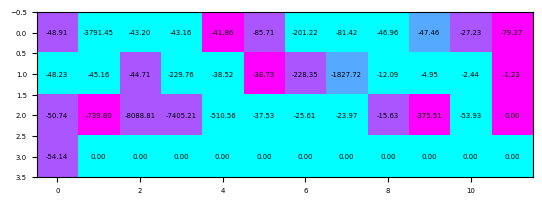

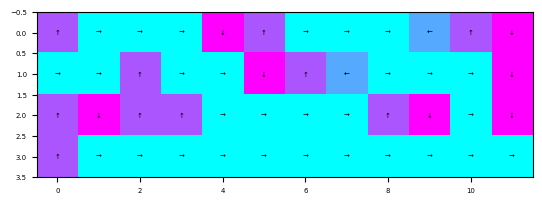

In [6]:
main()